In [1]:
import numpy as np
import tensorflow as tf
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile
import scipy as sp
import scipy.io as sio
from scipy.misc import *
import h5py as h5
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
from PIL import Image
from scipy import misc
%matplotlib inline
import load_data

# Process the input and output data

In [2]:
def bboxHelper(f, attr):
        if len(attr) > 1:
            attr = [f[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

## Data representation - train.tar.tgz contains all images in .png and labels bounding box in matlab format digitStruct.mat
The digitStruct.mat file contains a struct called digitStruct with the same length as the number of original images. Each element in digitStruct has the following fields: name which is a string containing the filename of the corresponding image. bbox which is a struct array that contains the position, size and label of each digit bounding box in the image. Eg: digitStruct(300).bbox(2).height gives height of the 2nd digit bounding box in the 300th image
http://ufldl.stanford.edu/housenumbers/

In [3]:
train_dir = './data/train/'
train_location = './data/train/digitStruct.mat'
test_dir = './data/test/digitStruct.mat'
extra_dir = './data/extra/digitStruct.mat'

f = h5.File(train_location, 'r')
groups = f['digitStruct'].items()

digitStructName = f['digitStruct']['name']
digitStructBbox = f['digitStruct']['bbox']

num_of_samples = len(digitStructName)


# Checkout some random  images with its labels.

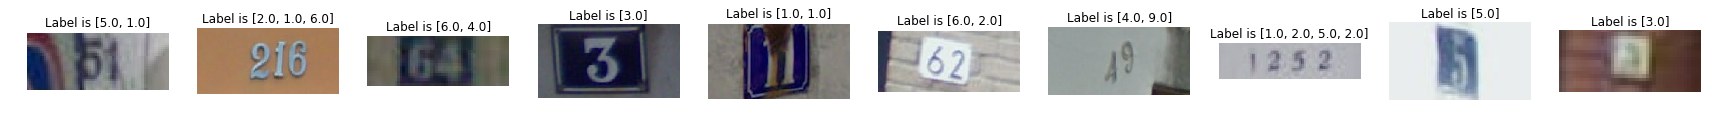

In [4]:
plt.rcParams['figure.figsize'] = (30.0, 30.0)
x, ax = plt.subplots(nrows=1, ncols=10)

for i in range(10):
    num = random.randrange(1, num_of_samples)
    ax[i].axis('off')
    bb = digitStructBbox[num].item()
    label = bboxHelper(f, f[bb]["label"])
    ax[i].set_title('Label is {}'.format(label), loc='center')
    name = ''.join([chr(c[0]) for c in f[digitStructName[num][0]].value])
    img_path = "./data/train/" + name
    image = mpimg.imread(img_path)
    ax[i].imshow(image)

In [5]:
import load_data

train_data, extra_data, test_data = load_data.parse_digitStruct(train_location, extra_dir, test_dir)

In [6]:
train_data[0]

{'boxes': [{'height': 219.0,
   'label': 1.0,
   'left': 246.0,
   'top': 77.0,
   'width': 81.0},
  {'height': 219.0, 'label': 9.0, 'left': 323.0, 'top': 81.0, 'width': 96.0}],
 'filename': '1.png'}

In [7]:
test_data[0]

{'boxes': [{'height': 30.0,
   'label': 5.0,
   'left': 43.0,
   'top': 7.0,
   'width': 19.0}],
 'filename': '1.png'}

In [8]:
extra_data[0]

{'boxes': [{'height': 56.0,
   'label': 4.0,
   'left': 24.0,
   'top': 70.0,
   'width': 38.0},
  {'height': 56.0, 'label': 7.0, 'left': 55.0, 'top': 41.0, 'width': 36.0},
  {'height': 56.0, 'label': 8.0, 'left': 79.0, 'top': 23.0, 'width': 47.0}],
 'filename': '1.png'}

In [9]:
print(len(train_data))

33402


In [10]:
print(len(test_data))

13068


In [11]:
print(len(extra_data))

202353


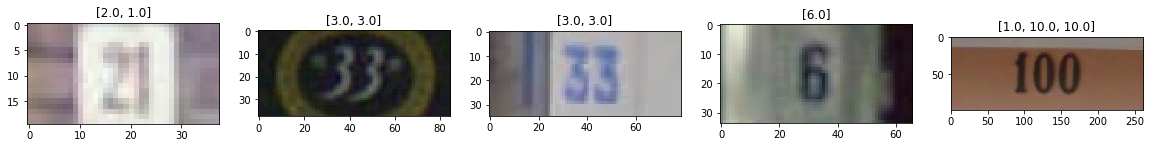

In [12]:
load_data.display_random_images(train_data, './data/train/', 5)

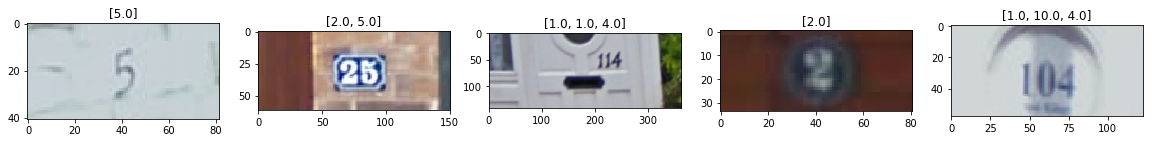

In [13]:
load_data.display_random_images(test_data, './data/test/', 5)

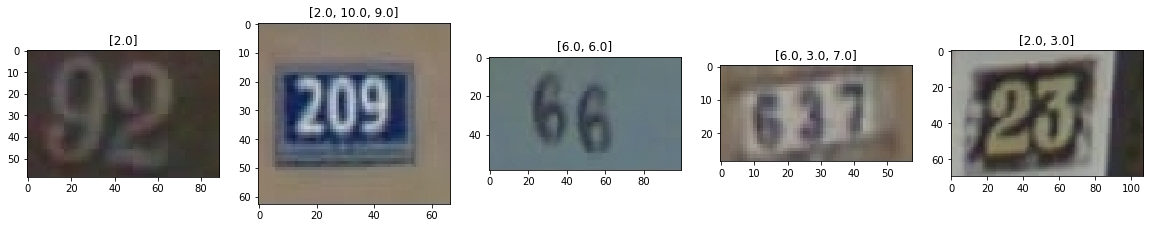

In [14]:
load_data.display_random_images(extra_data, './data/extra/', 5)

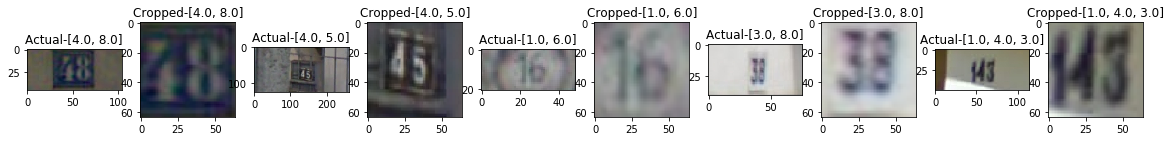

In [15]:
load_data.display_rand_cropped_images(train_data, './data/train/')

In [16]:
train_dataset, train_labels = load_data.get_dataset(train_data, './data/train/')


./data/train/29930.png has more than 5 digits


In [17]:
test_dataset, test_labels = load_data.get_dataset(test_data, './data/test/')

In [18]:
print("Training data Shape", train_dataset.shape)
print("Labels data Shape", train_labels.shape)

Training data Shape (33402, 64, 64, 3)
Labels data Shape (33402, 6)


In [45]:
print("Test data Shape", test_dataset.shape)
print("Labels data Shape", test_labels.shape)

Test data Shape (13068, 64, 64, 3)
Labels data Shape (13068, 6)


In [46]:
extra_dataset, extra_labels = load_data.get_dataset(extra_data, './data/extra/.')

In [47]:
print("Extra data Shape", extra_dataset.shape)
print("Labels data Shape", extra_labels.shape)

Extra data Shape (202353, 64, 64, 3)
Labels data Shape (202353, 6)


In [48]:
concat_train_samples = np.concatenate((train_dataset, extra_dataset), axis=0)
concat_train_labels = np.concatenate((train_labels, extra_labels), axis=0)
train_samples_data, train_samples_labels, validation_samples, validation_labels = load_data.split_to_train_and_validation(
                                                                            concat_train_samples, 
                                                                            concat_train_labels)

In [23]:
train_samples_data.shape

(188604, 64, 64, 3)

In [24]:
train_samples_labels.shape

(188604, 6)

In [25]:
validation_samples.shape

(47151, 64, 64, 3)

In [26]:
validation_labels.shape

(47151, 6)

In [49]:
def convert_labels(labels):
    new_labels = np.zeros(shape=len(labels))
    for index, sample_label in enumerate(labels):
        mul =0
        for digit in range(5,-1, -1):               
            if (sample_label[digit] == 10):
                continue
            if(digit ==0):
                continue
            new_labels[index] += labels[index][digit] *10**mul
            mul +=1
    return new_labels

In [50]:
train_num_labels = np.zeros(shape=len(train_samples_labels))

for index, sample_label in enumerate(train_samples_labels):
    mul =0
    for digit in range(5,-1, -1):               
        if (sample_label[digit] == 10):
            continue
        if(digit ==0):
            continue
        train_num_labels[index] += train_samples_labels[index][digit] *10**mul
        mul +=1  

In [51]:
train_label = convert_labels(train_samples_labels)

In [52]:
print(train_label.shape)
print(train_label[7])

(188604,)
744.0


In [31]:
validation_label = convert_labels(validation_labels)

In [32]:
test_label = convert_labels(test_labels)

In [33]:
print(validation_label.shape)
print(validation_label[1])

(47151,)
28.0


In [34]:
print(test_label.shape)
print(test_label[2])

(13068,)
6.0


# Build The network

In [54]:
def conv2d_maxpool(x, output_size, kernel_size, conv_stride_size, pool_size, pool_stride):

    shape = x.get_shape().as_list()
    W_conv1 = tf.Variable(tf.random_normal([kernel_size,kernel_size,shape[3],output_size],stddev=0.1))
    b_conv1 = tf.zeros([output_size])
    conv = tf.nn.conv2d(x, W_conv1, strides=[1,conv_stride_size, conv_stride_size,1], padding='SAME') + b_conv1
    conv = tf.nn.relu(conv)
    max_pool = tf.nn.max_pool(conv, ksize=[1,pool_size,pool_size,1], strides=[1,pool_stride,pool_stride,1], padding='SAME')
    return max_pool

In [55]:
def flatten(x):
    shape = x.get_shape().as_list()
    dim = np.prod(shape[1:])
    x2 = tf.reshape(x, [-1, dim])
    return x2

In [56]:
def fully_conn_relu(x, num_outputs):
    shape = x.get_shape().as_list()
    W_fc = tf.Variable(tf.random_normal([shape[1], num_outputs],stddev=0.1))
    b_fc = tf.zeros(num_outputs)
    fc = tf.nn.relu(tf.matmul(x, W_fc) + b_fc)
    return fc

In [57]:
def output(x, num_output):
    shape = x.get_shape().as_list()
    W_fc = tf.Variable(tf.random_normal([shape[1], num_output],stddev=0.1))
    b_fc = tf.zeros(num_output)
    output = tf.matmul(x, W_fc) + b_fc
    return output

In [58]:
num_classes = 11
def conv_net(x, keep_prob):
    conv1 = conv2d_maxpool(tf_input, 32, 5, 2, 2, 2)
    drop_data = tf.nn.dropout(conv1, keep_prob)

    conv2 = conv2d_maxpool(drop_data, 32,5,2, 2, 2)
    flatten_output = flatten(tf_input)
    flat_shape = flatten_output.get_shape().as_list()
    fc1 = fully_conn_relu(flatten_output, 1024)
    print(fc1.shape)
    return fc1

In [67]:
def build_rnn(input, lstm_size, keep_prob, lstm_layers):
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    initial_state = cell.zero_state(batch_size, tf.float32)
    outputs, final_state = tf.nn.dynamic_rnn(cell, input, sequence_length=[64,1024],
                                             initial_state=initial_state, time_major = True)
    return outputs, final_state

In [68]:
lstm_size = 128
lstm_layers = 1

In [69]:
def conv_net_with_rnn(x, keep_prob):
    cnn_output = conv_net(x, keep_prob)
    rnn_output, state = build_rnn(cnn_output,lstm_size, keep_prob,lstm_layers)

In [70]:
epochs = 16
batch_size = 64
keep_probability = 0.5

In [71]:
tf.reset_default_graph()

# Inputs
tf_input = tf.placeholder(tf.float32, shape=[None, 64, 64, 3],name='tf_input')
tf_output = tf.placeholder(tf.int64, shape=[None], name='tf_output')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# Model
logits,state = conv_net_with_rnn(tf_input, keep_prob)

cost =  tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits1, labels=tf_output[:]))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
prediction = tf.nn.softmax(logits)
equality = tf.equal(prediction, tf_output[:])
acc = tf.reduce_mean(tf.cast(equality, tf.float32))

(?, 1024)


ValueError: Shape (?, 1024) must have rank at least 3

In [34]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    session.run([optimizer], feed_dict={tf_input:feature_batch, tf_output:label_batch, keep_prob: keep_probability})
    #pass

In [35]:
def print_train_stats(sess, epoch, features_input, feature_labels):
    loss = sess.run(cost, feed_dict={tf_input:features_input, tf_output:feature_labels, keep_prob: 1})
    train_acc = sess.run(acc,feed_dict={tf_input:features_input, tf_output:feature_labels, keep_prob: 1})
    print("Epoch", epoch, "Training Loss=", loss, "Train Accuracy=", train_acc)

In [36]:
def print_valid_stats(sess, features_input, feature_labels):
    valid_acc = sess.run(acc,feed_dict={tf_input:features_input, tf_output:feature_labels, keep_prob: 1})
    print("Validation Acc=", valid_acc)

In [37]:
def test_trained_data(sess): 
    test_steps = int(len(test_data) / batch_size)
    cap_input = test_dataset[0:test_steps*batch_size, :,:,:]
    cap_output = test_labels[0:num_of_steps*batch_size, :]
    test_batch_acc_total = 0
    num_of_batches=0

    for steps in range(test_steps):
        offset = steps * batch_size
        test_input_batch = cap_input[offset: (offset +batch_size), :, :, :]
        test_ouput_batch = cap_output[offset: (offset +batch_size), :]
        test_acc = sess.run(acc,
                feed_dict={tf_input:test_input_batch, tf_output:test_ouput_batch, keep_prob: 1})
        test_batch_acc_total += test_acc
        num_of_batches += 1
    
    print("Test Accuracy", test_batch_acc_total/num_of_batches)

In [38]:
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    valid_offset =0
    num_of_steps = int(len(train_samples_data) / batch_size)
    cap_input = train_samples_data[0:num_of_steps*batch_size, :,:,:]
    cap_output = train_samples_labels[0:num_of_steps*batch_size, :]
    for epoch in range(epochs):
        if valid_offset > (len(validation_samples)-batch_size):
            valid_offset=0
        offset =0
        for steps in range(num_of_steps):
            offset = steps * batch_size
            train_input_batch = cap_input[offset: (offset +batch_size), :, :, :]
            train_ouput_batch = cap_output[offset: (offset +batch_size), :]
            train_neural_network(sess,optimizer, keep_probability, train_input_batch, train_ouput_batch)
            if (steps % 500 == 0):
                print_train_stats(sess,epoch, train_input_batch, train_ouput_batch)
                valid_input_batch = validation_samples[valid_offset:(valid_offset+batch_size), :,:,:]
                valid_labels_batch = validation_labels[valid_offset:(valid_offset+batch_size),:]
                print_valid_stats(sess, valid_input_batch, valid_labels_batch)
                valid_offset +=1
    test_trained_data(sess)
    

Epoch 0 Training Loss= 52.1721 Train Accuracy= 0.5375
Validation Acc= 0.21875
Epoch 0 Training Loss= 20.9344 Train Accuracy= 0.803125
Validation Acc= 0.6875
Epoch 0 Training Loss= 25.4833 Train Accuracy= 0.778125
Validation Acc= 0.753125
Epoch 0 Training Loss= 15.8369 Train Accuracy= 0.8
Validation Acc= 0.809375
Epoch 0 Training Loss= 14.259 Train Accuracy= 0.790625
Validation Acc= 0.81875
Epoch 0 Training Loss= 12.7867 Train Accuracy= 0.8375
Validation Acc= 0.840625
Epoch 1 Training Loss= 11.0622 Train Accuracy= 0.853125
Validation Acc= 0.859375
Epoch 1 Training Loss= 6.65561 Train Accuracy= 0.878125
Validation Acc= 0.8375
Epoch 1 Training Loss= 8.83964 Train Accuracy= 0.825
Validation Acc= 0.846875
Epoch 1 Training Loss= 7.21685 Train Accuracy= 0.828125
Validation Acc= 0.875
Epoch 1 Training Loss= 4.99283 Train Accuracy= 0.85625
Validation Acc= 0.8375
Epoch 1 Training Loss= 6.18907 Train Accuracy= 0.846875
Validation Acc= 0.83125
Epoch 2 Training Loss= 7.51276 Train Accuracy= 0.8375


# Test Accuracy